# Grouping and aggregating data

Most of the time, in pandas, we use `.groupby()` to group and aggregate data. This is a function that splits your data into certain categories, and then performs an aggregation, transformation, or filtration to those categories. Today we will only be looking at `.groupby()` and aggregations, and how they can help us to analyse our data. We will also learn about `resample()` as an alternative, more concise way to group dates and times.

As always, let's start by reading the data:

In [ ]:
import pandas as pd

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands_cl.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

In [ ]:
ol_df = orderlines_cl.copy()

In [ ]:
ol_df.info()

Change `date` to datetime.

In [ ]:
ol_df["date"] = pd.to_datetime(ol_df["date"])

## 1.&nbsp; `.groupby` a single feature

When we use the `.groupby()` method, we always state in the parentheses the name of the column that contains the categories that should be grouped. For example, we are grouping here by the product number (SKU), which will give us one line per sku. `.count()` will tell us how many rows have been condensed into each group.

In [ ]:
ol_df.groupby("sku").count()

Notice how in this "grouped" DataFrame we have 6798 rows: one row for each unique `sku`. In the original DataFrame we had many more rows:

In [ ]:
ol_df.shape

As you can see above, the same number of rows were condensed for each column, this is to be expected when we use `count()` as the aggregation function. However, if we use an aggregate such as `.sum()`, then we get the total for the condensed values of each column:

In [ ]:
# here we use numeric=true as ol_df contains a datetime column, which is excluded by using this parameter
# by default numeric_only = False

ol_df.groupby("sku").sum(numeric_only=True)

Now, obviously, not all of the information above matters: it's not relevant what the sum of the `id`'s is. So, let's select the `product_quantity` and see how many units of each product were sold:

In [ ]:
ol_df.groupby("sku")["product_quantity"].sum()

It can be useful sometimes to sort the values from highest to lowest. With the `.sum()` of `product_quantity` this will help us to see how many of each item we sold in order of quantity.

In [ ]:
(
    ol_df
    .groupby("sku")
    ["product_quantity"].sum()
    .sort_values(ascending=False)
)

In [ ]:
products_cl.loc[products_cl['sku']=='APP1190']

In [ ]:
ol_df.loc[ol_df['product_quantity']>50].merge(products_cl,
                                              on='sku',
                                              how='left'
                                              ).merge(orders_cl,
                                                      left_on='id_order',
                                                      right_on='order_id',
                                                      how='left'
                                                      )[
                                                  ['unit_price',
                                                   'product_quantity',
                                                   'desc',
                                                   'name',
                                                   'state']]

Or if you wish for only a certain number of the largest or smallest numbers, remember you can use `.nlargest()` or `.nsmallest()`

In [ ]:
(
    ol_df
    .groupby("sku")
    ["product_quantity"].sum()
    .nlargest(5)
)

### 1.1.&nbsp; List of aggregates

It is possible to use many different aggregates besides just `.sum()` and `.count()`. A full list can be found [here](https://pandas.pydata.org/docs/reference/groupby.html), and below are a few of the most useful.

* `.count()` – Number of non-null observations
* `.sum()` – Sum of values
* `.mean()` – Mean of values
* `.median()` – Median of values
* `.min()` – Minimum
* `.max()` – Maximum
* `.std()` – Standard deviation

### 1.2.&nbsp; `.agg()`
We are not restricted to only using one aggregate at a time. We can use the `.agg()` method to see multiple aggregates at once.

#### 1.2.1.&nbsp; multiple aggregates for one column
Here we first `.groupby()` the `sku`'s, then take the column `product quantity`, and look at both the `.sum()` and `.count()` of `product_quantity`. We also here reduced our DataFrame to the 10 largest `sku`"s according to the `.sum()` of `product_quantity`.

> **Tip:** when working with many Pandas methods chained one after the other, wrap all the statement in parenthesis and add a line break before any `.method()`. It will improve the readability of the code*

In [ ]:
(
    ol_df
    .groupby("sku")
    ["product_quantity"].agg(["sum", "count"])
    .nlargest(10, "sum")
)

#### 1.2.2.&nbsp; mutliple aggregates for more than one column
Not only can we look at multiple aggregates for one column. We can also look at multiple aggregates over multiple columns. Here we again `.groupby()` `sku` and take the `.sum()` and `.count()` of `product_quantity`, **and also** look at the `.mean()` of the `unit_price`.

In [ ]:
(
    ol_df
    .groupby("sku")
    .agg({"product_quantity": ["sum", "count"], "unit_price": "mean"})
    .nlargest(10, ("product_quantity", "sum"))
)

## 2.&nbsp; `.groupby()` multiple features
It's also possible to `.groupby()` multiple categories. Let's see how many products we sold each month.

In [ ]:
(
    ol_df
    .groupby([ol_df["date"].dt.year,
              ol_df["date"].dt.month])["product_quantity"]
    .sum()
 )

Looks like the end of the year and the begining of the year are the busiest times.

### 1.4.&nbsp; `.groupby()` aggregate plotting
It's also possible to quickly plot aggregates with `.groupby()`, which can help us better understand the data. Let's plot the above values showing how many products we sold each month.

In [ ]:
(
    ol_df.groupby([ol_df["date"].dt.year,
                   ol_df["date"].dt.month])
    ["product_quantity"].sum()
    .plot(figsize=(16, 12))
);

## 3.&nbsp; `.resample()`

Resampling allows us to easily aggregate time series data. When using `.resample()`, we have to define:
- The frequency of time for which to group the data (e.g. 5 minutely, hourly, daily...) expressed as a "frequency string" (`"W"` for weekly, `"ME"` for month end...). Find all available frequency strings [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).
- The column with the dates group by needs to be passed to the `on` parameter (unless you want group by the index).
- The aggregate function (`sum()`, `count()`, `mean()`...)
- The numerical column/s to aggregate.

With this we can easily recreate our groupby above, where we looked at the amount of products sold each month. The date displayed is the last day of the given month.

In [ ]:
(
    ol_df
    .resample("ME", on="date")
    ["product_quantity"].sum()
    .sort_values(ascending=False)
)

We can also quickly plot a daily graph for the amount of products sold.

In [ ]:
(
    ol_df
    .resample("1D3H", on="date")
    ["product_quantity"].sum()
    .plot(figsize=(12, 8))
 );

We can create the same graph as above using `.groupby()`, it just takes a little more code

In [ ]:
(
    ol_df
    .groupby([ol_df.date.dt.month])
    ["product_quantity"].mean()
    .plot.bar(figsize=(12, 8))
 );

As you can see from the x-axis of the two charts above, `.resample()` works a little more inuitvely when you want to group by datetimes. This isn't to say that you cannot use `.groupby()` with datetimes, of course you can. `.resample()` just provides us with a little extra flexibility to group datetime by specific groups. For example, you can create `.resample()` input strings such as `2H20min` for groups of 2 hours 20minutes, `3min` for groups of 3 minutes, `1D3H` for 1 day 3hours etc...

# Challenges

## Challenge 1. What are the top 8 most sold products?

In [8]:
# your code here
(
    ol_df
    .groupby("sku")
    ["product_quantity"].sum()
    .nlargest(8)
)

,product_quantity
sku,
APP1190,5576
APP0698,2337
WDT0183,1828
APP1922,1663
APP0927,1618
SAM0074,1346
APP1970,1182
APP1221,1131


## Challenge 2. How many products did each of the 5 largest orders contain?

In [12]:
# your code here
(
  ol_df.groupby("id_order")
  .agg({"product_quantity" : "sum",
        'sku':'nunique'})
  .nlargest(5, columns='product_quantity')
)

,product_quantity,sku
id_order,,
346221,999,1
349475,800,1
349133,555,1
335057,202,2
417536,200,1


## Challenge 3. We want to see how busy the days of the week are to know when we need more staff. Rank the days of the week from busiest to least busy.
Bonus points for using your pandas plotting skills.

<Axes: xlabel='weekday'>

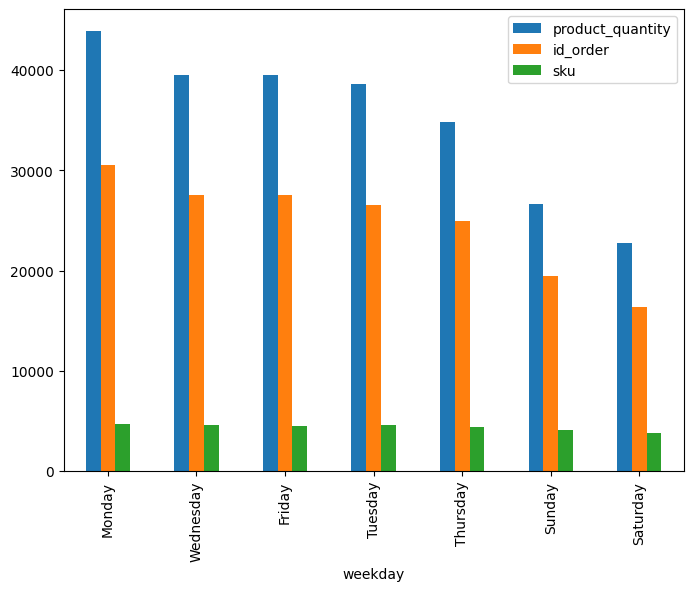

In [30]:
# your code here
ol_df['weekday'] = ol_df["date"].dt.day_name()
(
  ol_df.groupby('weekday')
  # Three different ways to measure how busy it is
  .agg({'product_quantity':'sum',
        'id_order':'nunique',
        'sku':'nunique'})
  .sort_values(by='product_quantity', ascending=False)
  .plot.bar(figsize=(8, 6))
);

## Challenge 4. Which brands sell the most products?

In [34]:
(brands['short'].str.len() !=3).sum()

0

In [35]:
(ol_df['sku'].str.len() != 7).sum()

11193

In [37]:
# your code here
sku_short = ol_df['sku'].str[:3]
brands_merged = brands.merge(ol_df, left_on='short', right_on=sku_short, how='inner')
brands_merged.groupby('long')['product_quantity'].sum().sort_values(ascending=False)

,product_quantity
long,
Apple,58210
OWC,12069
Western Digital,9821
Pack,8004
Crucial,7955
...,...
Acme,3
Retrak Utopia,3
Opulus,2


## Challenge 5. Plot a line chart for the amount of orders each hour of November 2017

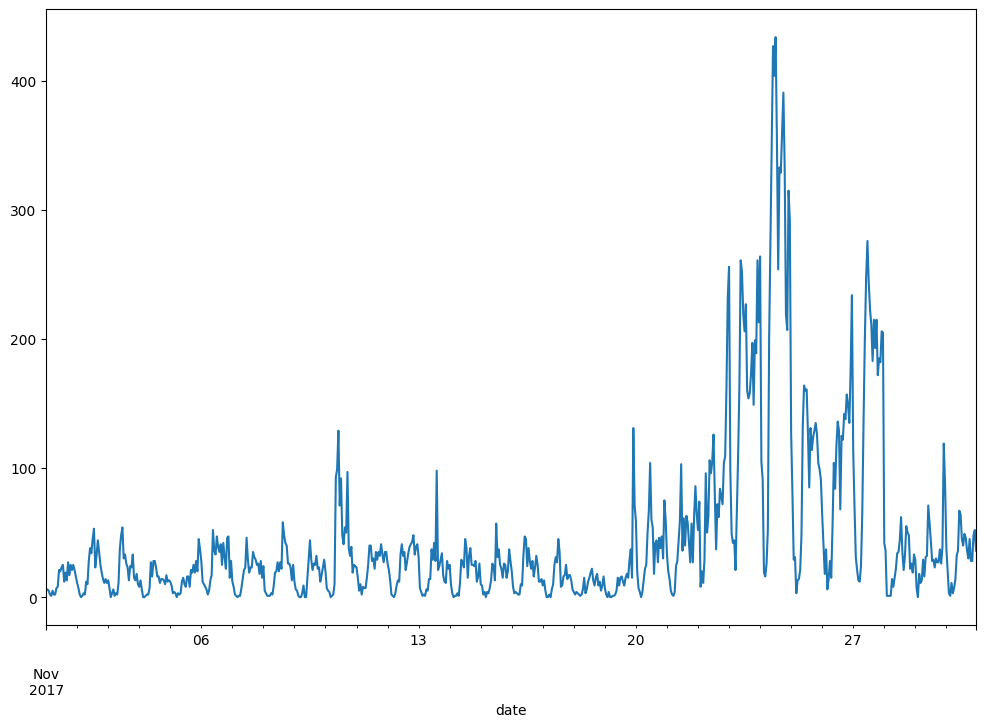

In [41]:
# month_mask = ol_df["date"].dt.month == 11
# year_mask =ol_df["date"].dt.year == 2017
date_mask = ol_df['date'].dt.strftime('%m, %Y') == '11, 2017'
(
    ol_df.loc[date_mask]
    .resample("h", on="date")
    ["product_quantity"].sum()
    .plot(figsize=(12, 8))
 );